Here are some preliminary results from analyzing the Andor iXon Ultra 888's gain

### Conventional Amplifier

| Settings        | gain       | (Andor-provied value)|
| --------------- | ---------- | ---------- |
| 0.1MHz, gain 2: | 0.79 e/ADC | 0.79 e/ADC |
| 0.1MHz, gain 1: | 3.39 e/ADC | 3.32 e/ADC |
| 1.0Mhz, gain 2: | 0.79 e/ADC | 0.79 e/ADC |
| 1.0Mhz, gain 1: | 3.41 e/ADC | 3.30 e/ADC |

#### Notes
* Two differend dark current responses, characterized through the guassian shaped distributions in the histogram of a stacked average dark current frame. The darkcurrent data was taken at -60 C, with a 5400s integration time.
  - 93% of pixels exhibited a darkcurrent of 10^-3 e-/s (primary dark current)
  - 5.7% exhibitied 10^-2 e-/s (secondary dark current)
  - and about 1.3% exhibited neither. Some of those pixels were random (hot pixels), but analysis of the histogram of this 1.3% of pixels suggests a pattern of guassian groupings, which if true would indicate a potential third and fourth characteristic dark current response. 
* While we are there, cooling performance. Andor hints, but doesn't outright say that the cooling and warming of the CCD needs to be controlled, to prevent undue stress on the chip. This temperature control appears to be handled by the application programming library. However, it becomes a concern in the event of improper shutdown, such as power loss. 
  - Air cooling: peak cooling -94 C; ambient temp 20 C; Delta -114 C
  - Water cooling: peak cooling -98 C; ambient temp 20 C; Delta -118
  - I tested the camera for excessive vibration from the coolant pump. While vibrations were apparent in the coolant feed line, imaging a circular test pattern revealed no difference in sharpness between having the pump on or off.
* further notes:
  - The fits header keywords will give contradictory info under certain circumstances, e.g. saying the gain is set to 2 in one keyword, and 1 in another
  - every now and again, it gets stuck in aquire mode. This has happened a confirmed 2 times, but has not been successfully reproduced.

In [28]:

from ccd_tools import *
from astropy.stats import sigma_clip
from scipy.stats import norm
from scipy.stats import linregress

def run_gain_analysis(main_path):
    
    # retrieve everything from the bias directory, ignoring files that are not fits
    bias_path = main_path + '/bias_frames'
    bias_files = get_filenames(bias_path, extension='.fits')

    # calculate read noise, from a couple of arbitrary frames
    with fits.open(bias_path + '/' + bias_files[0]) as bias_hdul:
        bias_frame1 = bias_hdul[0].data
    with fits.open(bias_path + '/' + bias_files[5]) as bias_hdul:
        bias_frame6 = bias_hdul[0].data

    print('Stats on', bias_files[0])
    print(sigma_clipped_stats(bias_frame1, sigma=4.0))
    print('stats on', bias_files[5])
    print(sigma_clipped_stats(bias_frame6, sigma=4.0))

    # calculate a master bias for this temperature
    bias_mean, bias_median, stacked_bias_stddev = sigma_clipped_frame_stats(bias_files, path=bias_path, sigma=4.0)
    master_bias_frame = bias_mean[0]


    # start of main calculations:
    sub_dir_list = get_filenames(main_path, extension='exposure', include_path=True)
    print(sub_dir_list)  # print to check the output

    # this makes a list of lists, with each entry in the outer list corresponding to a
    # subdirectory, and each inner list being the file names withing that subdirectory
    sub_dir_filenames = []
    for sub_dir in sub_dir_list:
        # retrieve the filenames, checking the extension to make sure
        sub_dir_filenames.append(get_filenames(sub_dir, extension='.fits', include_path=True))

    # open an instance of DS9, to select a fairly flat region of data
    pyds9.ds9_targets()
    ds9 = pyds9.DS9(target='display')

    # in DS9, make a box region that avoids the edges of the image, to avoid any sort of trail-off or other edge
    # weirdness. Make sure that this region is flat to within a factor of two
    input('Pause while you select data. Press enter to continue')
    selection = get_ds9_region(ds9, get_data=False)

    # now pull the signal analysis: variance, signal level, and calculated gain
    variance = []
    signal = []
    gain = []
    exposure_time = []
    for exposure in sub_dir_filenames:
        for n, file in enumerate(exposure):
            with fits.open(exposure[n]) as frame1:
                with fits.open(exposure[n-1]) as frame2:
                    # store the exposure time
                    time = frame1[0].header['exposure']
                    exposure_time.append(float(time))
                    
                    # bias subtract the frame
                    frame1_data = frame1[0].data.astype('float32') - master_bias_frame
                    frame2_data = frame2[0].data.astype('float32') - master_bias_frame

                    # crop the data down to what was selected, and sigma clip it
                    frame1_data = sigma_clip(frame1_data[selection.ymin:selection.ymax, selection.xmin:selection.xmax], sigma=5.0)
                    frame2_data = sigma_clip(frame2_data[selection.ymin:selection.ymax, selection.xmin:selection.xmax], sigma=5.0)

                    frame_diff = frame1_data - frame2_data  # order of subtraction is arbitrary
                    frame_var = np.var(frame_diff)
                    frame_signal = np.median(np.asarray([frame1_data, frame2_data]))

                    # diagnostic stuff
                    # print('differential average:', np.mean(frame_diff))
                    # print('fraction of signal:', np.mean(frame_diff)/frame_signal)
                    # print('expected error:', np.sqrt(frame_var/frame_diff.size))
                    # # display the frame difference
                    # display_data(frame_diff)

                    # # histogram the frame difference
                    # plt.figure(exposure[n])
                    # plt.hist(frame_diff.compressed(), bins=np.arange(frame_diff.min(), frame_diff.max(), step=1), density=True)
                    # # add the fit of a guassian to this
                    # gmean, gstd = norm.fit(frame_diff.compressed())
                    # print('norm fit parameters:', gmean, gstd)
                    # print('std dev of data used in fit:', np.std(frame_diff.compressed()))
                    # xmin, xmax = plt.xlim()
                    # x = np.linspace(xmin, xmax, 1000)
                    # y = norm.pdf(x, gmean, gstd)
                    # plt.plot(x, y)

                    # # histogram one of the frames
                    # plt.figure(exposure[n] + 'signal')
                    # plt.hist(frame1_data.flatten(), bins=np.arange(-350.5, 350.5, step=1) + 3800)
                    # plt.show()

                    # store signal
                    signal.append(frame_signal)
                    # store variance
                    variance.append(frame_var)
                    # store calculated gain, gain=signal/var * sqrt(2)
                    gain.append(frame_signal/frame_var * 2)


    plt.figure('gain vs signal')
    plt.scatter(signal, gain)
    plt.ylim(0, 4)
    plt.title('gain measured from difference frames, as a function of signal from those frames.')
    plt.ylabel('gain (e-/ADC)')
    plt.xlabel('signal from a difference of frames (ADC)')

    plt.figure('ptc')
    plt.scatter(signal, variance)
    plt.title('photon transfer curve')
    plt.xlabel('Signal (ADC)')
    plt.ylabel('Variance (ADC)')

    # clipped the signal for where the gain deviates. 
    # Gain should be about the same for all values, if it is not, that indicates either saturation or read noise floor
    clipped_gain = sigma_clip(gain, sigma=3.0)
    clipped_signal = np.ma.array(signal, mask=clipped_gain.mask)ressed())
    slope = fitresult[0]
    intercept = fitresult[1]
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)
    y = intercept + slope*x
    plt.plot(x, y, label='fit to slope')
    plt.legend()

    measured_gain = 1/slope*2
    print('Gain measured from slope of ptc:', measured_gain)
    
    plt.figure('exposure time vs signal')
    plt.scatter(exposure_time, np.asarray(signal)*measured_gain)
    plt.title('signal as a function of integration time')
    plt.xlabel('itegration time (s)')
    plt.xscale('log', basex=2)
    plt.ylabel('signal (e-)')
    plt.yscale('log')
    
    return measured_gain



SyntaxError: invalid syntax (<ipython-input-28-14e54f863b34>, line 121)

Stats on im20190804T221933n000007.fits
(499.6951627301895, 500.0, 1.8977796054889755)
stats on im20190804T221933n000009.fits
(499.712563650878, 500.0, 1.899121629387776)
['/home/lee/Data/illumination_data_gain1_1MHz/64s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/2s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/16s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/40s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/4s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/point5s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/32s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/1s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/48s_exposure', '/home/lee/Data/illumination_data_gain1_1MHz/8s_exposure']
Pause while you select data. Press enter to continue
Gain measured from slope of ptc: 3.4063964185026805


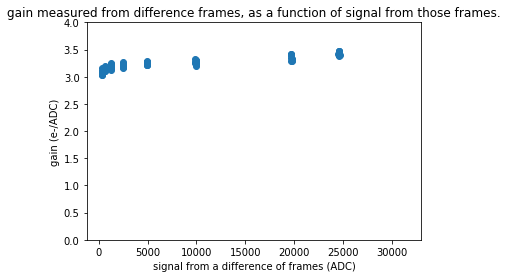

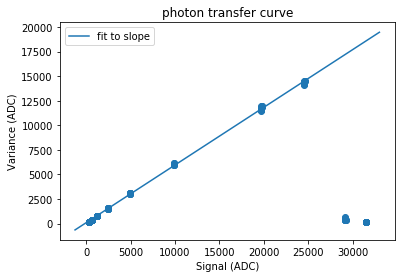

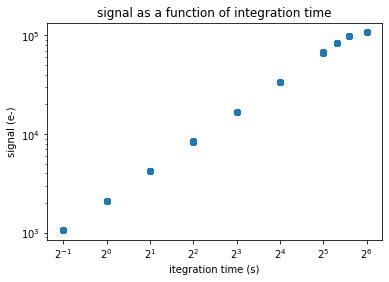

In [29]:
# analyze the 1MHz, gain 1 setting. 
data_path = '/home/lee/Data/illumination_data_gain1_1MHz'
# main_path = '/home/lee/Data/illumination_data_gain2_100kHz'
gain = run_gain_analysis(data_path)

Stats on im20190725T232231n000000.fits
(500.9145152414279, 501.0, 5.954139875479138)
stats on im20190725T232231n000009.fits
(499.05941695160976, 499.0, 5.968125267880291)
['/home/lee/Data/illumination_data_gain2_1MHz/2s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/16s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/24s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/4s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/point5s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/point1s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/32s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/1s_exposure', '/home/lee/Data/illumination_data_gain2_1MHz/8s_exposure']
Pause while you select data. Press enter to continue
Gain measured from slope of ptc: 0.7859129554845655


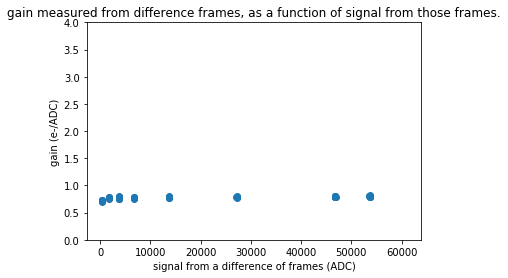

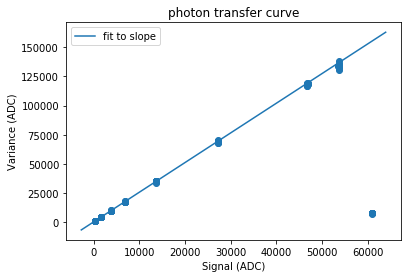

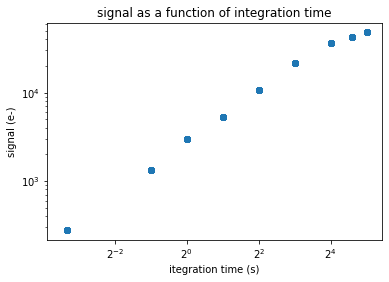

In [30]:
# analyze the 1MHz, gain 2 setting. 
data_path = '/home/lee/Data/illumination_data_gain2_1MHz'
gain = run_gain_analysis(data_path)

Stats on im20190805T214442n000009.fits
(500.09385687989396, 500.0, 1.4250253414526346)
stats on im20190805T214442n000004.fits
(500.3902233379369, 500.0, 1.4230610548001668)
['/home/lee/Data/illumination_data_gain1_100kHz/2s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/16s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/40s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/4s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/point5s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/32s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/1s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/48s_exposure', '/home/lee/Data/illumination_data_gain1_100kHz/8s_exposure']
Pause while you select data. Press enter to continue
Gain measured from slope of ptc: 3.393089261344722


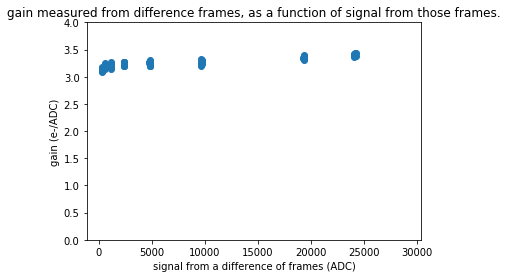

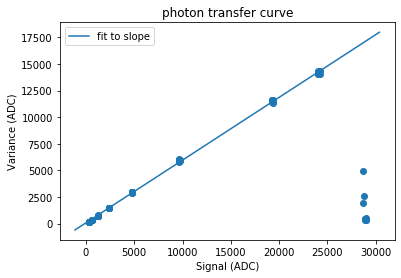

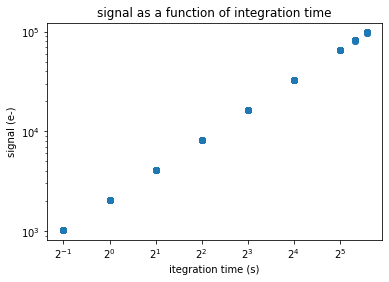

In [26]:
# analyze the 0.1MHz, gain 1 setting. 
data_path = '/home/lee/Data/illumination_data_gain1_100kHz'
gain = run_gain_analysis(data_path)

Stats on im20190802T205204n000000.fits
(499.8774032523721, 500.0, 3.580376837079302)
stats on im20190802T205204n000001.fits
(499.82431427154467, 500.0, 3.5805712843237436)
['/home/lee/Data/illumination_data_gain2_100kHz/2s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/16s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/24s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/4s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/point5s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/32s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/1s_exposure', '/home/lee/Data/illumination_data_gain2_100kHz/8s_exposure']
Pause while you select data. Press enter to continue
Gain measured from slope of ptc: 0.7914545239272922


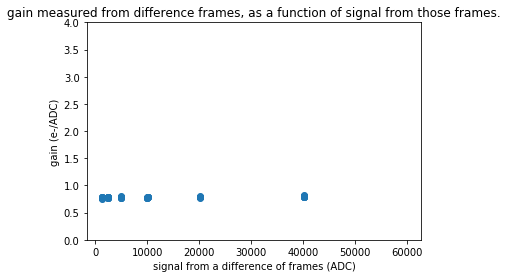

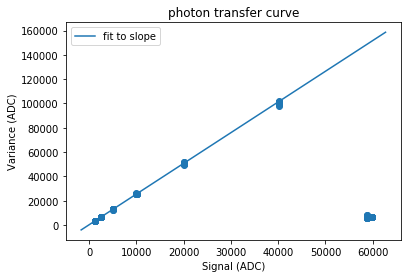

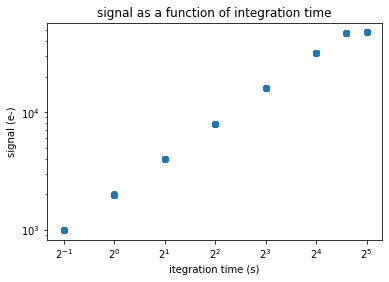

In [31]:
# analyze the 0.1MHz, gain 2 setting. 
data_path = '/home/lee/Data/illumination_data_gain2_100kHz'
gain = run_gain_analysis(data_path)